In [139]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [140]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         0.34.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.8
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.16
albumentations                     1.4.15
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.19.0
astropy                            6.1.4
astropy-iers-data                  0.2024.9.30.0.32.59
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread         

In [141]:
import tensorflow as tf
import os

In [142]:
# Optimizing the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [143]:
import cv2
import imghdr
from matplotlib import pyplot as plt

data_dir = "/content/data"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']


#Getting rid of unwanted images for training data (not valid image or not valid extension is gone!)
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)

    except Exception as e:
      print('Issue with image {}'.format(image_path))
      #os.remove(image_path)

In [144]:
#tf.data.Dataset

In [145]:
import numpy as np
from matplotlib import pyplot as plt

# Data Generator -> On the fly thus we need iterator to repeatedly grab data (data pipeline)
data = tf.keras.utils.image_dataset_from_directory('/content/data')

data_iterator = data.as_numpy_iterator()

# Grabbing one batch
batch = data_iterator.next()

Found 271 files belonging to 2 classes.


In [146]:
# Images represented as NumPy arrays
batch[0].shape

(32, 256, 256, 3)

In [147]:
# Class 1 - > Sad People, Class 0 -> Happy People
batch[1]

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int32)

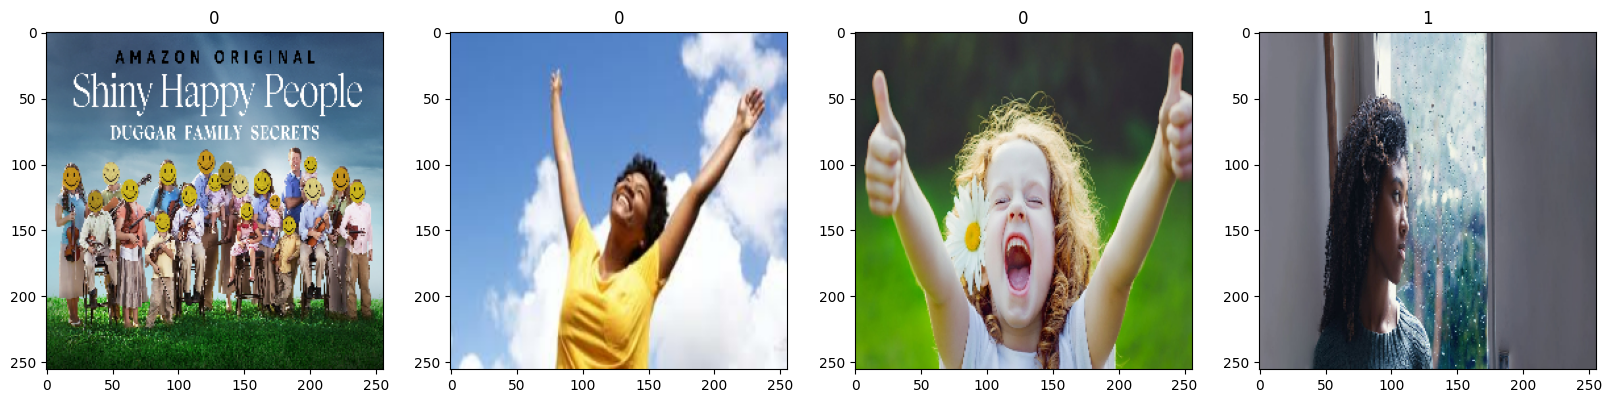

In [148]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [149]:
# Preprocessing Data!
# Scale data to optimize performance

data = data.map(lambda x,y: ((x/255),y))

scaled_it = data.as_numpy_iterator()

batch = scaled_it.next()



In [150]:
batch[0].max()

1.0

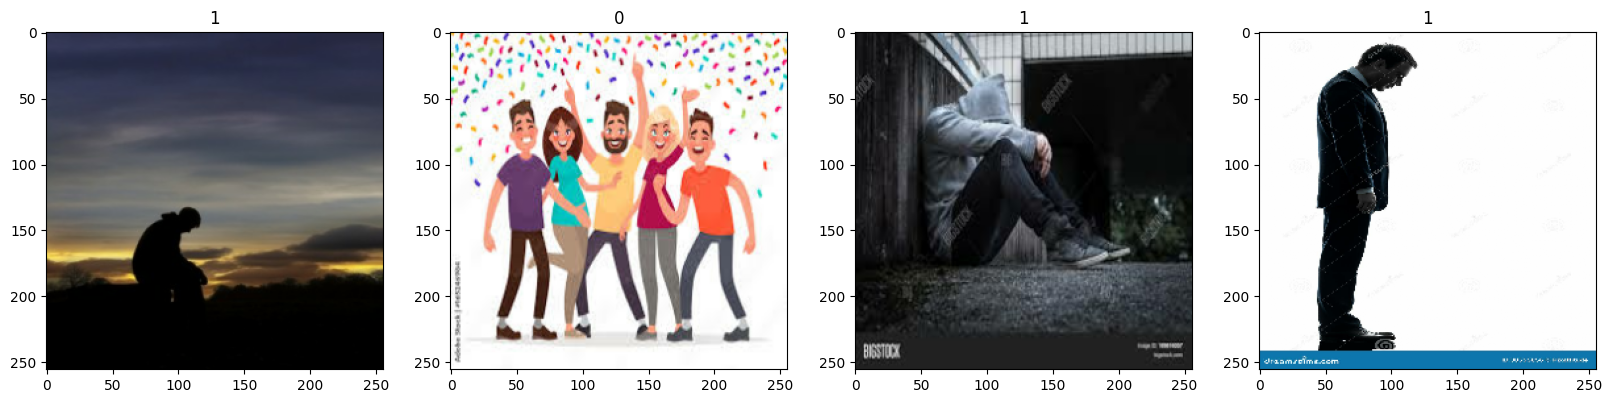

In [151]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [152]:
# Training Data -> used to train it, Validation Data -> evaluatation while training to increase accuracy, Test Partition -> not useful until final evaluation
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [153]:
train  = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [155]:
model = Sequential()

In [156]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation="sigmoid"))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [157]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [158]:
logdir = '/content/logs'

# To see how model is doing and optimizing certain tasks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])



Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5330 - loss: 0.9372 - val_accuracy: 0.5312 - val_loss: 0.6072
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5807 - loss: 0.5978 - val_accuracy: 0.8750 - val_loss: 0.5787
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7990 - loss: 0.5461 - val_accuracy: 0.8750 - val_loss: 0.4717
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8242 - loss: 0.4486 - val_accuracy: 0.7812 - val_loss: 0.4516
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8510 - loss: 0.4025 - val_accuracy: 0.9375 - val_loss: 0.3072
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8580 - loss: 0.3368 - val_accuracy: 0.9375 - val_loss: 0.2785
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8887 - loss: 0.2624 - val_accuracy: 0.8750 - val_loss: 0.2946
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9127 - loss: 0.2832 - val_accuracy: 0.9375 - val_loss: 0.1932
Epoch 9/

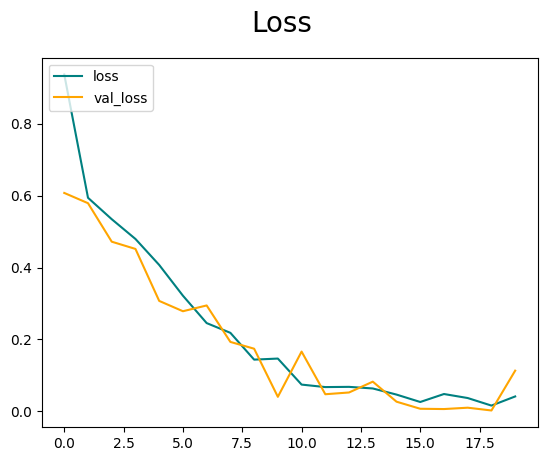

In [159]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

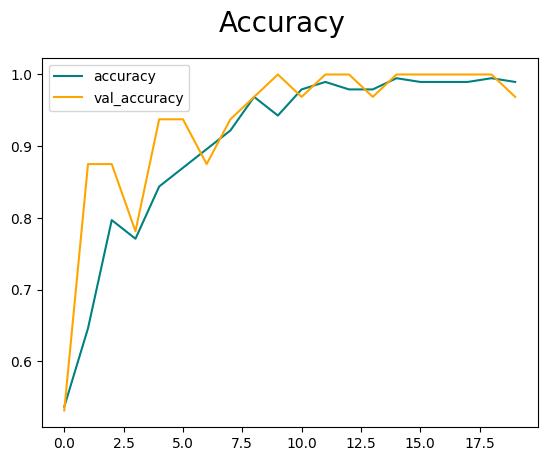

In [160]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [171]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  yhat = yhat > 0.5  # Convert probabilities to class predictions
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)


In [172]:
print(f"Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision:0.0, Recall:0.0, Accuracy: 0.0


In [163]:
import cv2

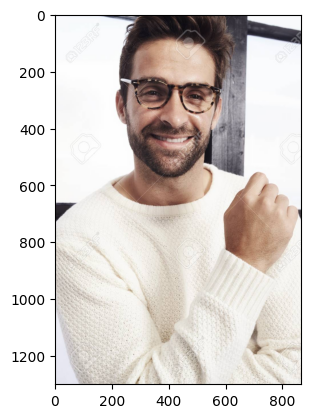

In [174]:
img =  cv2.imread("/content/happydude.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

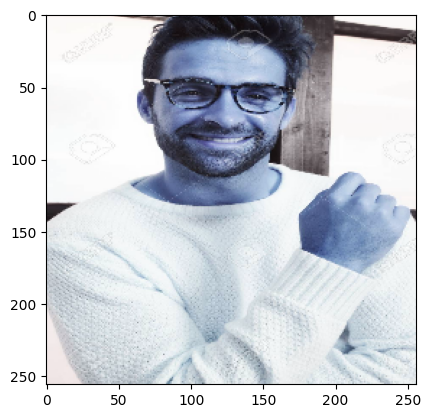

In [175]:
resize =  tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [166]:
np.expand_dims(resize, 0)

array([[[[255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,
         [253.     , 253.     , 253.     ],
         [249.     , 254.     , 253.     ],
         [249.     , 254.     , 253.     ]],

        [[255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,
         [253.     , 253.     , 253.     ],
         [249.     , 254.     , 253.     ],
         [249.     , 254.     , 253.     ]],

        [[255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,
         [253.     , 253.     , 253.     ],
         [252.90625, 253.02344, 253.     ],
         [249.     , 254.     , 253.     ]],

        ...,

        [[255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         [255.     , 255.     , 255.     ],
         ...,


In [176]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [177]:
yhat

array([[0.9082382]], dtype=float32)

In [178]:
#Reversed
if yhat > 0.5:
  print("Predicted class is Happy!")

else :
  print("Predicted class is Sad!")


Predicted class is Happy!
